In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from keras.models import Sequential
from keras.regularizers import L2, L1L2, L1
from keras import regularizers
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from sklearn.metrics import accuracy_score, classification_report
from keras.models import load_model
import tensorflow as tf
from keras.regularizers import L1L2
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# EDA

In [168]:
df_train = pd.read_csv("train_preprocess.csv")
df_test = pd.read_csv("test_data.csv")

In [169]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  1100 non-null   object
 1   labels  1100 non-null   object
dtypes: object(2)
memory usage: 17.3+ KB


In [170]:
df_train.head()

,tweets,labels
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [171]:
df_train.tail()

,tweets,labels
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative
10999,meskipun sering belanja ke yogya di riau junct...,positive


In [172]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  11000 non-null  object
 1   labels  11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [173]:
df_train.isna().sum()

tweets    0
labels    0
dtype: int64

In [174]:
df_train.duplicated().sum()

67

In [175]:
# displays the number of columns and rows of the dataframe

shape = df_train.shape
print("Number of columns and number of rows (columns, rows) : \n {}".format(shape))

Number of columns and number of rows (columns, rows) : 
 (11000, 2)


In [176]:
df_train.labels.value_counts()

labels
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

Terlihat bahwa data imbalance berdasarkan jumlah label. Pada tahap preprocessing data sebelum Modeling harus dilakukan balancing

In [177]:
def cleansing(text):
    # Make sentence being lowercase
    text = text.lower()

    # Remove user, rt, \n, retweet, \t, url, xd
    pattern_1 = r'(user|retweet|\\t|\\r|url|xd)'
    text = re.sub(pattern_1, '', text)

    # Remove mention
    pattern_2 = r'@[^\s]+'
    text = re.sub(pattern_2, '', text)

    # Remove hashtag
    pattern_3 = r'#([^\s]+)'
    text = re.sub(pattern_3, '', text)

    # Remove general punctuation, math operation char, etc.
    pattern_4 = r'[\,\@\*\_\-\!\:\;\?\'\.\"\)\(\{\}\<\>\+\%\$\^\#\/\`\~\|\&\|]'
    text = re.sub(pattern_4, ' ', text)

    # Remove single character
    pattern_5 = r'\b\w{1,1}\b'
    text = re.sub(pattern_5, '', text)

    # Remove emoji
    pattern_6 = r'\\[a-z0-9]{1,5}'
    text = re.sub(pattern_6, '', text)

    # Remove digit character
    pattern_7 = r'\d+'
    text = re.sub(pattern_7, '', text)

    # Remove url start with http or https
    pattern_8 = r'(https|https:)'
    text = re.sub(pattern_8, '', text)

    # Remove (\); ([); (])
    pattern_9 = r'[\\\]\[]'
    text = re.sub(pattern_9, '', text)

    # Remove character non ASCII
    pattern_10 = r'[^\x00-\x7f]'
    text = re.sub(pattern_10, '', text)

    # Remove character non ASCII
    pattern_11 = r'(\\u[0-9A-Fa-f]+)'
    text = re.sub(pattern_11, '', text)

    # Remove multiple whitespace
    pattern_12 = r'(\s+|\\n)'
    text = re.sub(pattern_12, ' ', text)
    
    # Remove whitespace at the first and end sentences
    text = text.rstrip()
    text = text.lstrip()

    # Pattern to look for three or more repetitions of any character, including newlines.
    pattern_13 = re.compile(r"(.)\1{1,}", re.DOTALL)
    text = re.sub(pattern_13, r"\1\1", text)
    return text

def tokenisasi(text):
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens

In [178]:
df_train['tweets'] = df_train['tweets'].apply(cleansing)
df_test['tweets'] = df_test['tweets'].apply(cleansing)

## Feature Engineering

In [179]:
df_train['total_word'] = df_train['tweets'].apply(lambda x: len(x.split()))
df_train['total_char'] = df_train['tweets'].apply(len)
df_train.head()

,tweets,labels,total_word,total_char
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,56,384
1,mohon ulama lurus dan k mmbri hujjah partai ap...,neutral,18,99
2,lokasi strategis di jalan sumatera bandung tem...,positive,28,172
3,betapa bahagia nya diri ini saat unboxing pake...,positive,15,89
4,duh jadi mahasiswa jangan sombong dong kasih k...,negative,32,200


## Descriptive Statistics

### Mean, Median, Mode

In [180]:
total_word_mean = df_train['total_word'].mean()
total_char_mean = df_train['total_char'].mean()

total_word_median = df_train['total_word'].median()
total_char_median = df_train['total_char'].median()

total_word_mode = df_train['total_word'].mode()
total_char_mode = df_train['total_char'].mode()


print(f"Mean dari total kata : {total_word_mean} \nMean dari total karakter : {total_char_mean}")
print("\n")
print(f"Median dari total kata : {total_word_median} \nMedian dari total karakter : {total_char_median}")
print("\n")
print(f"Mode dari total kata : {total_word_mode} \nMode dari total karakter : {total_char_mode}")

Mean dari total kata : 28.977 
Mean dari total karakter : 179.98618181818182


Median dari total kata : 25.0 
Median dari total karakter : 152.0


Mode dari total kata : 0    8
Name: total_word, dtype: int64 
Mode dari total karakter : 0    62
Name: total_char, dtype: int64


### Range

Digunakan untuk mencari perbedaan antara nilai terbesar dengan nilai terkecil pada data.

In [181]:
range_total_word = df_train.total_word.max() - df_train.total_word.min() 
range_total_word

84

### IQR dan Mencari Outlier

In [182]:
# cari nilai minimum
p0 = df_train.total_word.min()

# cari nilai maksimum
p100 = df_train.total_word.max()

# cari Quartile 1
q1 = df_train.total_word.quantile(0.25)

#cari Quartile 2
q2 = df_train.total_word.quantile(0.5)

#cari Quartile 3
q3 = df_train.total_word.quantile(0.75)

# cari IQR
iqr = q3 - q1

# cari batas bawah
lower_limit = q1-1.5*iqr

# cari batas atas
upper_limit = q3+1.5*iqr

# menentukan batas outlier dari data yang kita punya :
# Cek apakah ada outlier dari batas bawah
print("Batas Bawah 'total_word' :", lower_limit)
print("Nilai minimum =", p0)
if lower_limit < p0 :
  print("Tidak ada outlier dari sisi batas bawah")
else :
  print("Ada outlier dari sisi batas bawah")

# Cek apa ada outlier dari batas atas
print("="*10)
print("Batas Atas 'total_word' :", upper_limit)
print("Nilai maksimum =", p100)
if upper_limit >  p100 :
  print("Tidak ada outlier dari sisi batas atas")
else :
  print("Ada outlier dari sisi batas atas")

Batas Bawah 'total_word' : -28.0
Nilai minimum = 1
Tidak ada outlier dari sisi batas bawah
Batas Atas 'total_word' : 84.0
Nilai maksimum = 85
Ada outlier dari sisi batas atas


### Variance

Digunakan untuk mengukur seberapa menyebar data yang ada dari mean-nya. Jika nilai variance dari suatu variabel/kolom lebih besar atau lebih kecil mean, maka nilai dari suatu variabel/kolom tersebut menjauhi mean.

In [183]:
print(f"Variance dari total kata : {df_train['total_word'].var()}")
print(f"Variance dari total karakter : {df_train['total_char'].var()}")

Variance dari total kata : 342.7096264205837
Variance dari total karakter : 13329.870342725371


### Standard Deviation

Digunakan untuk mengukur penyebaran observasi dalam kumpulan data relatif terhadap rata-ratanya. Jika nilai standard deviation dari suatu variabel/kolom lebih besar atau lebih kecil mean, maka data dari suatu variabel/kolom tersebut menjauhi mean.


In [184]:
print(f"Standard Deviasi dari total kata : {df_train['total_word'].std()}")
print(f"Standard Deviasi dari total karakter : {df_train['total_char'].std()}")

Standard Deviasi dari total kata : 18.512418167829498
Standard Deviasi dari total karakter : 115.45505767494714


### Skewness
Merupakan suatu cara untuk mengukur ketidaksimetrisan suatu distribusi nilai.

*   Apabila nilai skewness = 0, maka menunjukkan data berdistribusi normal.
*   Apabila nilai skewness < 0, maka menunjukkan skewness bernilai negatif.
*   Apabila nilai skewness > 0, maka menunjukkan skewness bernilai positif.

In [185]:
print(f"Skewness dari total kata : {df_train['total_word'].skew()}")
print(f"Skewness dari total karakter : {df_train['total_char'].skew()}")

Skewness dari total kata : 0.5363526153086788
Skewness dari total karakter : 0.5701888121311052


Dapat terlihat bahwa total word dan total karakter dari data memiliki skewness positif (Cenderung jatuh ke kanan)

### Kurtosis
Merupakan suatu cara untuk menunjukan derajat keruncingan, semakin besar nilai kurtosis maka kurva semakin runcing.

Kurtosis memiliki kondisi sebagai berikut:

*   Kurtosis yang memiliki nilai 3 berarti memiliki Distribusi Normal
*   Jika nilai Kurtosis kurang dari 3, dikatakan bersifat playkurtik, yang berarti cenderung menghasilkan lebih sedikit nilai outlier.
*   Jika nilai kurtosis lebih besar dari 3, dikatakan leptokurtik, yang berarti cenderung menghasilkan lebih besar nilai outlier.

In [186]:
print(f"Kurtosis dari total kata : {df_train['total_word'].kurtosis()}")
print(f"Kurtosis dari total karakter : {df_train['total_char'].kurtosis()}")

Kurtosis dari total kata : -0.8070109297373467
Kurtosis dari total karakter : -0.7465383430461019


## Visualization

Selain dengan pendekatan Descriptive Statistic, untuk mengetahui insight melalui Univariate Analysis bisa menggunakan visualisasi. 

Berikut contoh visualisasi Pie Chart untuk melihat persebaran total sentimen per kelasnya.

Berdasarkan gambar di bawah terlihat sentimen terbanyak ada di sentimen positif, selanjutnya sentimen negatif, dan yang terakhir sentimen netral. 

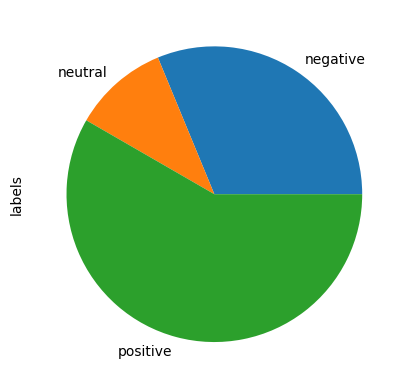

In [187]:
df_train.groupby('labels').labels.count().plot(kind='pie')
plt.savefig("pie_labels.png", bbox_inches = 'tight', dpi=300)

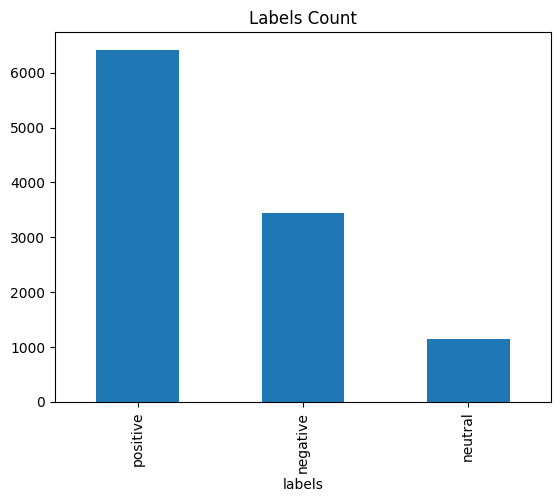

In [188]:
df_train.labels.value_counts().plot(kind='bar')
plt.title("Labels Count")
plt.savefig("labels_count.png", bbox_inches = 'tight', dpi=300)

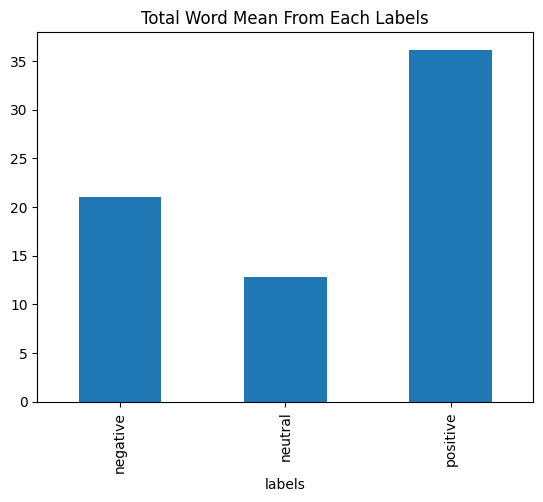

In [189]:
df_train.groupby('labels').total_word.mean().plot(kind='bar')
plt.title("Total Word Mean From Each Labels")
plt.savefig("word_class.png", bbox_inches = 'tight', dpi=300)

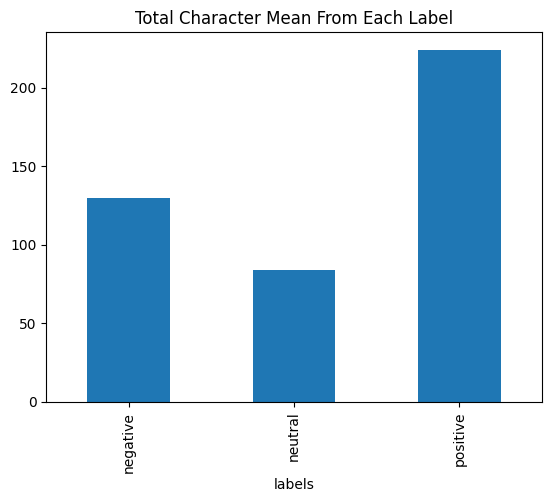

In [190]:
df_train.groupby('labels').total_char.mean().plot(kind='bar')
plt.title("Total Character Mean From Each Label")
plt.savefig("char_class.png", bbox_inches = 'tight', dpi=300)

## Histogram

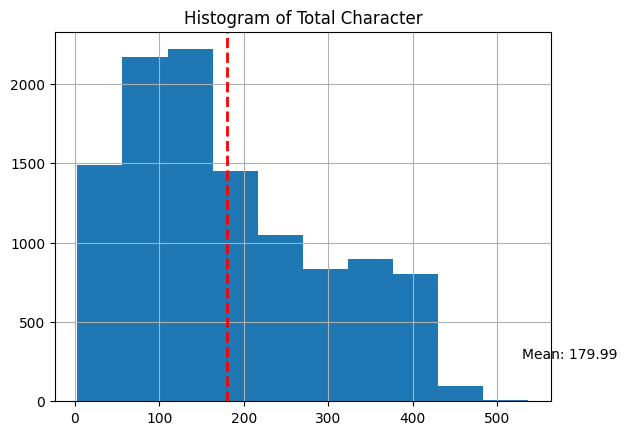

In [191]:
df_train.total_char.hist()
plt.title("Histogram of Total Character")
plt.axvline(total_char_mean, color='r', linestyle='dashed', linewidth=2)
plt.text(x = df_train.total_char.max()-8, y = df_train.total_char.max()*0.5, s = 'Mean: {:.2f}'.format(total_char_mean), size = 10)
plt.savefig("hist_total_char.png", dpi=300)

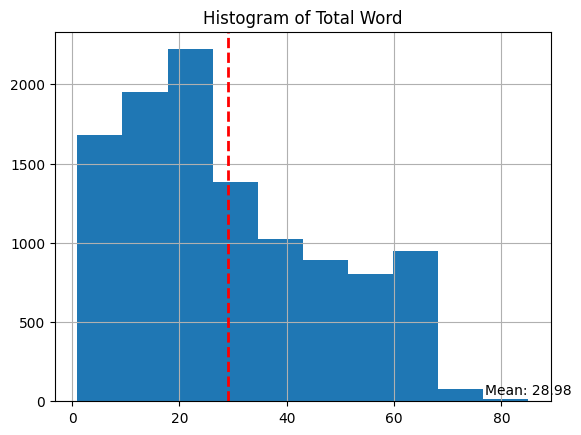

In [192]:
df_train.total_word.hist()
plt.title("Histogram of Total Word")
plt.axvline(total_word_mean, color='r', linestyle='dashed', linewidth=2)
plt.text(x = df_train.total_word.max()-8, y = df_train.total_word.max()*0.5, s = 'Mean: {:.2f}'.format(total_word_mean), size = 10)
plt.savefig("hist_total_word.png", bbox_inches = 'tight', dpi=300)

### Histogram & Filter Sentiment

Kita bisa memfilter data berdasarkan sentimen setelah itu memvisualisasikannya dalam bentuk Histogram.


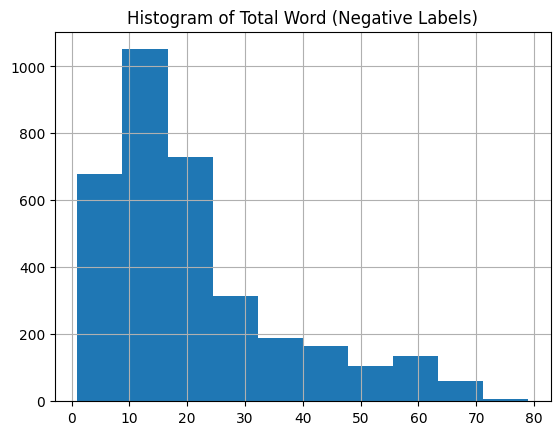

In [193]:
# misal visualisasi hanya berdasarkan sentimen negatif 
df_negative = df_train.loc[df_train['labels'] == 'negative']
df_negative['total_word'].hist()
plt.title("Histogram of Total Word (Negative Labels)")
plt.savefig("hist_total_word_neg.png", bbox_inches = 'tight', dpi=300)

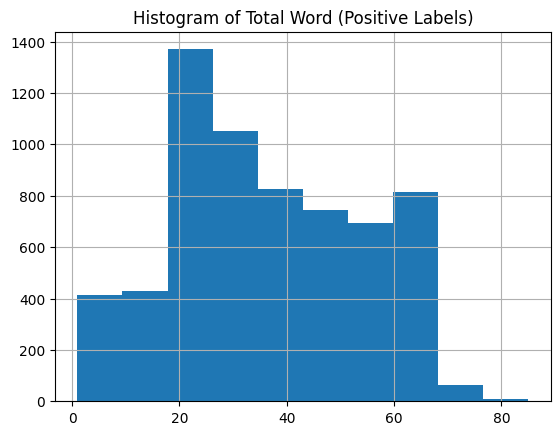

In [194]:
# misal visualisasi hanya berdasarkan sentimen positive
df_positive = df_train.loc[df_train['labels'] == 'positive']
df_positive['total_word'].hist()
plt.title("Histogram of Total Word (Positive Labels)")
plt.savefig("hist_total_word_pos.png", bbox_inches = 'tight', dpi=300)

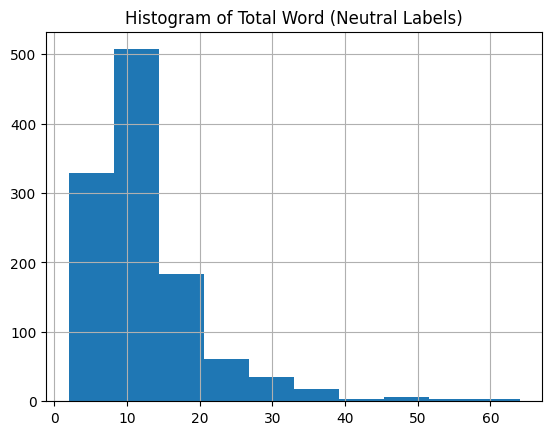

In [195]:
# misal visualisasi hanya berdasarkan sentimen neutral
df_neutral = df_train.loc[df_train['labels'] == 'neutral']
df_neutral['total_word'].hist()
plt.title("Histogram of Total Word (Neutral Labels)")
plt.savefig("hist_total_word_neut.png", bbox_inches = 'tight', dpi=300)

## Wordcloud

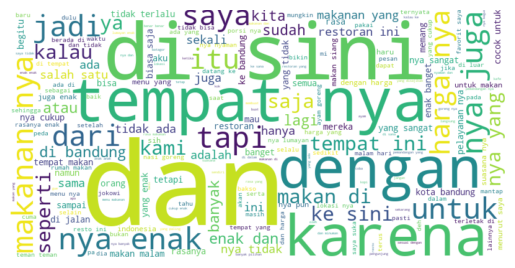

In [196]:
# merge all text from dataframe (df)
text = ' '.join(df_train['tweets'].to_list())

# create a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(text)

# displays the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("wordcloud.png", bbox_inches = 'tight', dpi=300)

In [197]:
# determine the word from df_train['tweet_without_stopwords'] that occurs frequently
import nltk
text = ' '.join(df_train['tweets'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))

[('nya', 13474), ('yang', 9337), ('dan', 7894), ('di', 7738), ('tidak', 4399), ('saya', 4309), ('dengan', 4025), ('enak', 3721), ('makanan', 3587), ('tempat', 3550)]


## Wordcloud (Negative Labels)

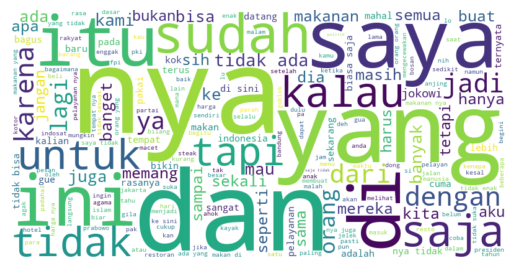

In [198]:
# merge all text from dataframe (df)
df_negative = df_train.loc[df_train['labels'] == 'negative']

text = ' '.join(df_negative['tweets'].to_list())

# create a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(text)

# displays the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("wordcloud_neg.png", bbox_inches = 'tight', dpi=300)

In [199]:
# determine the word from df_train['tweet_without_stopwords'] that occurs frequently
import nltk
text = ' '.join(df_negative['tweets'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))

[('nya', 2350), ('tidak', 1939), ('yang', 1738), ('dan', 1246), ('di', 1210), ('saya', 1082), ('ini', 764), ('saja', 657), ('dengan', 641), ('itu', 625)]


## Wordcloud (Positive Labels)

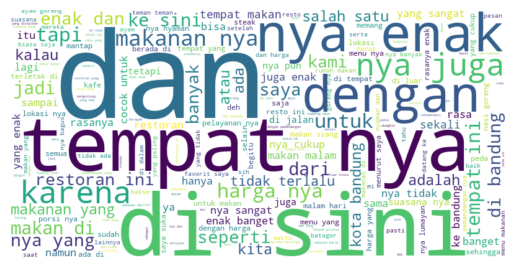

In [200]:
# merge all text from dataframe (df)
df_positive = df_train.loc[df_train['labels'] == 'positive']

text = ' '.join(df_positive['tweets'].to_list())

# create a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(text)

# displays the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("wordcloud_pos.png", bbox_inches = 'tight', dpi=300)

In [201]:
# determine the word from df_train['tweet_without_stopwords'] that occurs frequently
import nltk
text = ' '.join(df_positive['tweets'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))

[('nya', 10918), ('yang', 7379), ('dan', 6430), ('di', 6190), ('enak', 3459), ('dengan', 3251), ('tempat', 3229), ('makanan', 3188), ('saya', 3098), ('ini', 2693)]


## Wordcloud (Netural Labels)

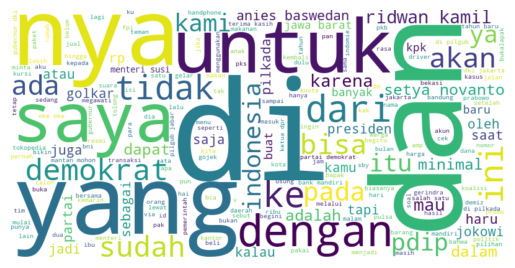

In [202]:
# merge all text from dataframe (df)
df_neutral = df_train.loc[df_train['labels'] == 'neutral']

text = ' '.join(df_neutral['tweets'].to_list())

# create a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(text)

# displays the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("wordcloud_neut.png", bbox_inches = 'tight', dpi=300)

In [203]:
# determine the word from df_train['tweet_without_stopwords'] that occurs frequently
import nltk
text = ' '.join(df_neutral['tweets'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))

[('di', 338), ('yang', 220), ('dan', 218), ('nya', 206), ('untuk', 145), ('dengan', 133), ('saya', 129), ('demokrat', 96), ('tidak', 92), ('ke', 91)]


## Counter untuk Mencari Bag of Words dari tiap Label

In [204]:
from collections import Counter

def get_word_frequency(label):
    words = []
    for text in df_train[df_train['labels'] == label]['tweets']:
        words += text.split()
    word_freq = Counter(words)
    return word_freq

pos_word_freq = get_word_frequency('positive')
neg_word_freq = get_word_frequency('negative')
ntrl_word_freq = get_word_frequency('neutral')

### Kata yang paling sering muncul pada label "positive"

In [205]:
pos_word_freq.most_common(10)

[('nya', 10918),
 ('yang', 7379),
 ('dan', 6430),
 ('di', 6190),
 ('enak', 3459),
 ('dengan', 3251),
 ('tempat', 3229),
 ('makanan', 3188),
 ('saya', 3098),
 ('ini', 2693)]

### Kata yang paling sering muncul pada label "negative"

In [206]:
neg_word_freq.most_common(10)

[('nya', 2350),
 ('tidak', 1939),
 ('yang', 1738),
 ('dan', 1246),
 ('di', 1210),
 ('saya', 1082),
 ('ini', 764),
 ('saja', 657),
 ('dengan', 641),
 ('itu', 625)]

### Kata yang paling sering muncul pada label "neutral"

In [207]:
ntrl_word_freq.most_common(10)

[('di', 338),
 ('yang', 220),
 ('dan', 218),
 ('nya', 206),
 ('untuk', 145),
 ('dengan', 133),
 ('saya', 129),
 ('demokrat', 96),
 ('tidak', 92),
 ('ke', 91)]

# Bivariate Analysis

In [209]:
df_train = df_train.select_dtypes(include=['int64', 'float64'])
df_train.corr()

,total_word,total_char
total_word,1.000000,0.993396
total_char,0.993396,1.000000


Korelasi antara total kata dengan total karakter dari masing-masing data sangat tinggi. Seperti kita ketahui, kata berasal dari kumpulan karakter. Mari kita buktikan dengan scatter plot

### Scatter Plot

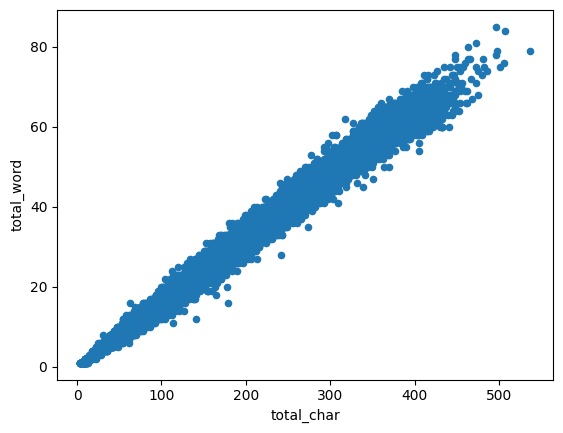

In [210]:
df_train.plot(x="total_char", y="total_word", kind='scatter')
plt.savefig("scatter_plot.png", bbox_inches = 'tight', dpi=300)

## Heatmap

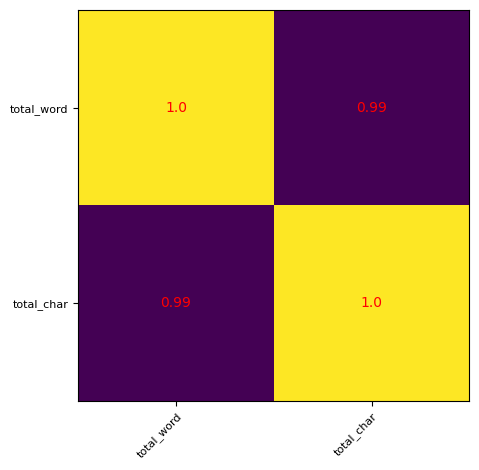

In [211]:
# get correlation matrix
corr = df_train.corr()
fig, ax = plt.subplots()
# create heatmap
im = ax.imshow(corr.values)
# set labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, fontsize=8)
ax.set_yticklabels(corr.columns, fontsize=8)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        text = ax.text(j, i, np.around(corr.iloc[i, j], decimals=2), ha="center", va="center", color="red", fontsize=10) # decrease font size of text annotations
plt.tight_layout() # adjust subplots to fit the figure size
plt.savefig("heatmap.png", bbox_inches = 'tight', dpi=300)
plt.show()

# **Modeling**

#### Sebelum tahap modeling ada beberapa proses, yaitu:
* Preprocessing Data (Cleansing data, cek outlier, splitting data, mengubah data teks menjadi numerikal)
* Balancing data (karena diketahui saat EDA bahwa pada data train terdapat imbalance label)

In [215]:
df_train = pd.read_csv("train_preprocess.csv")
df_test = pd.read_csv("test_data.csv")

In [216]:
def cleansing(text):
    # Make sentence being lowercase
    text = text.lower()

    # Remove user, rt, \n, retweet, \t, url, xd
    pattern_1 = r'(user|retweet|\\t|\\r|url|xd)'
    text = re.sub(pattern_1, '', text)

    # Remove mention
    pattern_2 = r'@[^\s]+'
    text = re.sub(pattern_2, '', text)

    # Remove hashtag
    pattern_3 = r'#([^\s]+)'
    text = re.sub(pattern_3, '', text)

    # Remove general punctuation, math operation char, etc.
    pattern_4 = r'[\,\@\*\_\-\!\:\;\?\'\.\"\)\(\{\}\<\>\+\%\$\^\#\/\`\~\|\&\|]'
    text = re.sub(pattern_4, ' ', text)

    # Remove single character
    pattern_5 = r'\b\w{1,1}\b'
    text = re.sub(pattern_5, '', text)

    # Remove emoji
    pattern_6 = r'\\[a-z0-9]{1,5}'
    text = re.sub(pattern_6, '', text)

    # Remove digit character
    pattern_7 = r'\d+'
    text = re.sub(pattern_7, '', text)

    # Remove url start with http or https
    pattern_8 = r'(https|https:)'
    text = re.sub(pattern_8, '', text)

    # Remove (\); ([); (])
    pattern_9 = r'[\\\]\[]'
    text = re.sub(pattern_9, '', text)

    # Remove character non ASCII
    pattern_10 = r'[^\x00-\x7f]'
    text = re.sub(pattern_10, '', text)

    # Remove character non ASCII
    pattern_11 = r'(\\u[0-9A-Fa-f]+)'
    text = re.sub(pattern_11, '', text)

    # Remove multiple whitespace
    pattern_12 = r'(\s+|\\n)'
    text = re.sub(pattern_12, ' ', text)
    
    # Remove whitespace at the first and end sentences
    text = text.rstrip()
    text = text.lstrip()

    # Pattern to look for three or more repetitions of any character, including newlines.
    pattern_13 = re.compile(r"(.)\1{1,}", re.DOTALL)
    text = re.sub(pattern_13, r"\1\1", text)
    return text

def tokenisasi(text):
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens

In [217]:
df_train['clean_tweets'] = df_train['tweets'].apply(cleansing)
df_test['clean_tweets'] = df_test['tweets'].apply(cleansing)

## Feature Engineering

In [218]:
df_train['word_tokens'] = df_train['clean_tweets'].apply(tokenisasi)
df_test['word_tokens'] = df_test['clean_tweets'].apply(tokenisasi)

In [219]:
df_train[['clean_tweets']][0:10]

,clean_tweets
0,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k mmbri hujjah partai ap...
2,lokasi strategis di jalan sumatera bandung tem...
3,betapa bahagia nya diri ini saat unboxing pake...
4,duh jadi mahasiswa jangan sombong dong kasih k...
5,makanan beragam harga makanan di food stall ak...
6,pakai kartu kredit bca tidak untung malah rugi...
7,tempat unik bagus buat foto makanan enak pegaw...
8,saya bersama keluarga baru saja menikmati peng...
9,bersyukur


## One Hot Encoding

In [220]:
le = LabelEncoder()

df_train['label_encode'] = le.fit_transform(df_train['labels'])
df_test['label_encode'] = le.transform(df_test['labels'])

display(df_train.head())

print(df_train.dtypes)

,tweets,labels,clean_tweets,word_tokens,label_encode
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...,"[warung, ini, dimiliki, oleh, pengusaha, pabri...",2
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k mmbri hujjah partai ap...,"[mohon, ulama, lurus, dan, k, mmbri, hujjah, p...",1
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung tem...,"[lokasi, strategis, di, jalan, sumatera, bandu...",2
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...,"[betapa, bahagia, nya, diri, ini, saat, unboxi...",2
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih k...,"[duh, jadi, mahasiswa, jangan, sombong, dong, ...",0


tweets          object
labels          object
clean_tweets    object
word_tokens     object
label_encode     int32
dtype: object


In [221]:
df_train.isna().sum()

tweets          0
labels          0
clean_tweets    0
word_tokens     0
label_encode    0
dtype: int64

In [222]:
# Menggabungkan setiap elemen dalam kolom 'word_tokens' menjadi satu string
df_train['string_tokens'] = df_train['word_tokens'].apply(' '.join)

In [223]:
df_train

,tweets,labels,clean_tweets,word_tokens,label_encode,string_tokens
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...,"[warung, ini, dimiliki, oleh, pengusaha, pabri...",2,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k mmbri hujjah partai ap...,"[mohon, ulama, lurus, dan, k, mmbri, hujjah, p...",1,mohon ulama lurus dan k mmbri hujjah partai ap...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung tem...,"[lokasi, strategis, di, jalan, sumatera, bandu...",2,lokasi strategis di jalan sumatera bandung tem...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...,"[betapa, bahagia, nya, diri, ini, saat, unboxi...",2,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih k...,"[duh, jadi, mahasiswa, jangan, sombong, dong, ...",0,duh jadi mahasiswa jangan sombong dong kasih k...
...,...,...,...,...,...,...
10995,tidak kecewa,positive,tidak kecewa,"[tidak, kecewa]",2,tidak kecewa
10996,enak rasa masakan nya apalagi kepiting yang me...,positive,enak rasa masakan nya apalagi kepiting yang me...,"[enak, rasa, masakan, nya, apalagi, kepiting, ...",2,enak rasa masakan nya apalagi kepiting yang me...
10997,hormati partai-partai yang telah berkoalisi,neutral,hormati partai partai yang telah berkoalisi,"[hormati, partai, partai, yang, telah, berkoal...",1,hormati partai partai yang telah berkoalisi
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative,pagi pagi di tol pasteur sudah macet parah bik...,"[pagi, pagi, di, tol, pasteur, sudah, macet, p...",0,pagi pagi di tol pasteur sudah macet parah bik...


In [224]:
# define a function to count the number of words in a string
def count_words(text):
    words = text.split()
    return len(words)

# apply the function to the DataFrame
df_train['num_words'] = df_train['string_tokens'].apply(count_words)

# calculate the average number of words per row
avg_words = df_train['num_words'].mean()

print("Average number of words per row: ", avg_words)

Average number of words per row:  28.977


In [225]:
df_train_copy = df_train.copy()

## Preprocessing Data

In [226]:
# Split data train
X_train, X_val, Y_train, Y_val = train_test_split(df_train_copy['string_tokens'], df_train_copy['labels'], test_size=0.10, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(9900,) (9900,)
(1100,) (1100,)


In [227]:
df_train_copy = pd.DataFrame({'string_tokens':X_train, 'labels': Y_train})
df_train_copy = df_train_copy.drop_duplicates()

X_train = df_train_copy['string_tokens']
Y_train = df_train_copy['labels']

## Cek kata-kata dalam data train yang tergolong ke dalam Outlier

[('nya', 12110), ('yang', 8377), ('dan', 7082), ('di', 6912), ('tidak', 3934), ('saya', 3891), ('dengan', 3584), ('enak', 3334), ('makanan', 3263), ('tempat', 3180)]


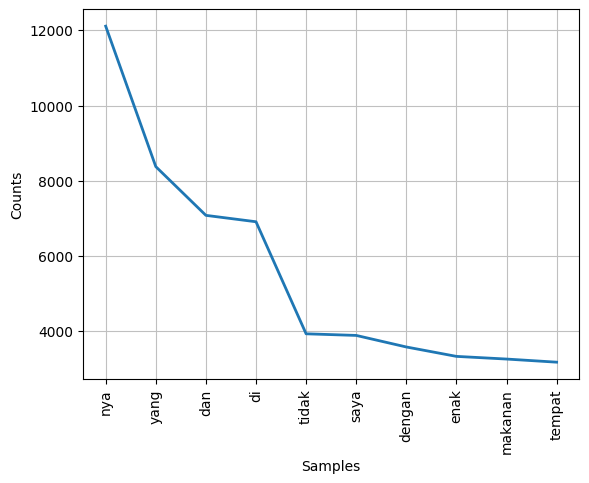

<Figure size 640x480 with 0 Axes>

In [228]:
# determine the word from df['tweet_without_stopwords'] that occurs frequently
text = ' '.join(df_train_copy['string_tokens'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))
freq_kata.plot(10, cumulative=False)
plt.savefig("line_bagwords.png", bbox_inches = 'tight', dpi=300)

In [229]:
# get the frequency distribution of words
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))

# calculate the interquartile range (IQR) of word frequency
q1, q3 = np.percentile(list(freq_kata.values()), [1, 99])
iqr = q3 - q1

# calculate the upper and lower bounds for outliers
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# get the words that are outliers
outliers = [word for word, freq in freq_kata.items() if freq > upper_bound or freq < lower_bound]
print(outliers)

['ada', 'ke', 'harga', 'saya', 'yang', 'makanan', 'tidak', 'enak', 'juga', 'nya', 'dari', 'di', 'sudah', 'dan', 'sangat', 'nyaman', 'orang', 'adalah', 'untuk', 'ini', 'tempat', 'banget', 'dengan', 'rasa', 'jadi', 'buat', 'sama', 'nasi', 'sini', 'suka', 'bandung', 'menu', 'cukup', 'banyak', 'suasana', 'malam', 'restoran', 'bagus', 'pemandangan', 'pelayanan', 'jalan', 'makan', 'bisa', 'saja', 'goreng', 'karena', 'kita', 'kalau', 'itu', 'tapi', 'ayam', 'rasanya', 'kami', 'sekali']


In [230]:
# define a function to remove words from DataFrame
def remove_outliers(row):
    words = row['string_tokens'].split()
    words = [word for word in words if word not in outliers]
    return ' '.join(words)

# apply the function to the DataFrame
X_train = df_train_copy.apply(remove_outliers, axis=1)

In [231]:
MAX_NB_WORDS = 15000
MAX_SEQUENCE_LENGTH = 64
EMBEDDING_DIM = 64

In [232]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

In [233]:
tokenizer.fit_on_texts(X_train)

# Tokenisasi data train
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
Y_train = pd.get_dummies(Y_train).values

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)
Y_val = pd.get_dummies(Y_val).values

# Tokenisasi data test
X_test = tokenizer.texts_to_sequences(df_test['clean_tweets'])
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
Y_test = pd.get_dummies(df_test['label_encode']).values

In [234]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Balancing Data

In [235]:
# inisiasi RandomOverSampler
ros = RandomOverSampler(random_state=42)

# lakukan oversampling pada kolom "tweets" dan "labels" dengan memanggil fungsi fit_resample()
X_resampled, y_resampled = ros.fit_resample(X_train, Y_train)

## LSTM

## CNN

In [236]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=64),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 2
history = model.fit(X_resampled, y_resampled, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val))

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(X_val, Y_val, verbose=2)
print("Test accuracy:", test_acc)

Epoch 1/2
539/539 [==============================] - 59s 105ms/step - loss: 0.3972 - accuracy: 0.8387 - val_loss: 0.4013 - val_accuracy: 0.8555
Epoch 2/2
539/539 [==============================] - 52s 97ms/step - loss: 0.0780 - accuracy: 0.9723 - val_loss: 0.5300 - val_accuracy: 0.8427
35/35 - 0s - loss: 0.5300 - accuracy: 0.8427 - 428ms/epoch - 12ms/step
Test accuracy: 0.8427272439002991


In [237]:
model.save("sentiment_analysis_model_CNN_challenge.h5")

d:\BINAR_CHALLENGE\PLATINUM_CHALLENGE\plat_challenge_main\plat_challenge_main\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [239]:
loaded_model_CNN = load_model("sentiment_analysis_model_CNN_challenge.h5")

### Validation

In [240]:
y_pred = loaded_model_CNN.predict(X_val)
y_pred.shape

35/35 [==============================] - 1s 14ms/step


(1100, 3)

In [241]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_val_classes = np.argmax(Y_val, axis=1)
accuracy = accuracy_score(Y_val_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.27%


In [242]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_val_classes = np.argmax(Y_val, axis=1)
print(classification_report(Y_val_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       342
           1       0.82      0.60      0.70       116
           2       0.88      0.91      0.89       642

    accuracy                           0.84      1100
   macro avg       0.83      0.77      0.79      1100
weighted avg       0.84      0.84      0.84      1100



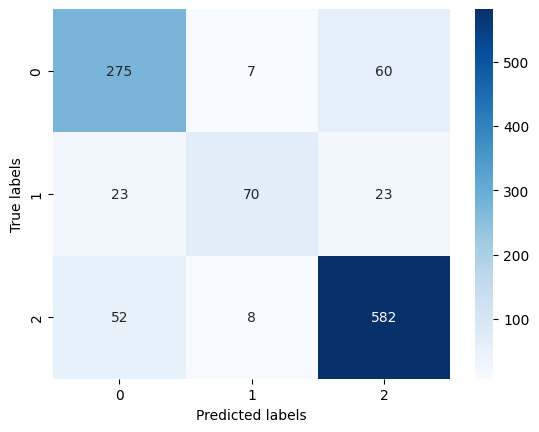

In [243]:
cm_CNN_val = confusion_matrix(Y_val_classes, y_pred_classes)

sns.heatmap(cm_CNN_val, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig("CM_CNN_val.png", bbox_inches = 'tight', dpi=300)
plt.show()

### Predict data test

In [244]:
y_pred = loaded_model_CNN.predict(X_test)
y_pred.shape

35/35 [==============================] - 1s 12ms/step


(1100, 3)

In [245]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
accuracy = accuracy_score(Y_test_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.00%


In [246]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       353
           1       0.97      0.98      0.97       121
           2       0.99      0.97      0.98       626

    accuracy                           0.97      1100
   macro avg       0.97      0.97      0.97      1100
weighted avg       0.97      0.97      0.97      1100



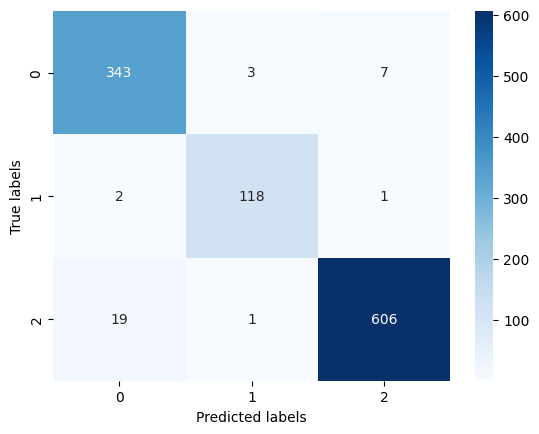

In [247]:
cm_CNN_test = confusion_matrix(Y_test_classes, y_pred_classes)

sns.heatmap(cm_CNN_test, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig("CM_CNN_test.png", bbox_inches = 'tight', dpi=300)
plt.show()

## Recurrent Neural Network

In [249]:
import pandas as pd

df_train = pd.read_csv('train_preprocess.csv')
df_valid = pd.read_csv('test_data.csv')

# df = df_train.append(df_valid, ignore_index=True)
df = pd.concat([df_train,df_valid], ignore_index=True)

In [250]:
df_test = pd.read_csv('test_data.csv')

# df = df.append(df_test, ignore_index=True)
df = pd.concat([df,df_test], ignore_index=True)

In [251]:
df.head()

,tweets,labels
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [252]:
df.shape

(13200, 2)

In [254]:
df.labels.value_counts()

labels
positive    7668
negative    4142
neutral     1390
Name: count, dtype: int64

# **Text Normalization/Cleansing**

Lalu kita lakukan cleansing sebagai berikut

In [255]:
import re 

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [257]:
df['clean_tweets'] = df.tweets.apply(cleansing)

In [258]:
df.head()

,tweets,labels,clean_tweets
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung t...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kas...


Sortir data dan label berdasarkan sentimen

In [260]:
neg = df.loc[df['labels'] == 'negative'].clean_tweets.tolist()
neu = df.loc[df['labels'] == 'neutral'].clean_tweets.tolist()
pos = df.loc[df['labels'] == 'positive'].clean_tweets.tolist()

neg_label = df.loc[df['labels'] == 'negative'].labels.tolist()
neu_label = df.loc[df['labels'] == 'neutral'].labels.tolist()
pos_label = df.loc[df['labels'] == 'positive'].labels.tolist()

In [261]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 7668, Neu: 1390, Neg: 4142
Total data: 13200


# **Feature Extraction**

Setelah itu kita lakukan Feature Extraction menggunakan modul "Tokenizer" dan "pad_sequences" dari Tensorflow. 

Module Tokenizer memungkinkan untuk memvektorisasi korpus teks, dengan mengubah setiap teks menjadi urutan bilangan bulat (setiap bilangan bulat menjadi indeks token dalam kamus) atau menjadi vektor di mana koefisien untuk setiap token bisa biner, berdasarkan jumlah kata , berdasarkan tf-idf.

Module pad_sequences memungkinkan mengubah list dari sequences menjadi array bentuk 2D.

In [262]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [263]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [264]:
Y

array([[False, False,  True],
       [False, False,  True],
       [False, False,  True],
       ...,
       [ True, False, False],
       [ True, False, False],
       [ True, False, False]])

In [265]:
labels

['positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',

# **Prepare train & test datasets/Splitting Dataset**

Split dataset menjadi 80% untuk train dan 20% untuk test.

In [266]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# **Training**

Jalankan training dengan metode RNN. Arsitektur RNN ini dibangun menggunakan framework Tensorflow.

In [267]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from keras import optimizers
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Flatten
from keras import backend as K

In [268]:
import sys

# Check if a virtual environment is active
is_virtualenv = hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix)

if is_virtualenv:
    print("A virtual environment is active.")
else:
    print("No virtual environment is active.")


A virtual environment is active.


In [269]:
!which python


'which' is not recognized as an internal or external command,
operable program or batch file.


In [270]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

Adapun arsitektur RNN yang dibangun sebagai berikut:


*   Input Layer: Data teks setelah dilakukan Feature Extraction, dikondisikan menjadi sebuah matrix berdimensi 100. 
*   Unit Layer: Pada bagian ini diterapkan unit/neuron sejumlah 64. Pada tahap ini pula fitur Dropout diterapkan guna meminimalisir overfitting.
*   Fully-connected Layer: Setelah proses convolution, dikondisikan sebagai input untuk Multi-layer Perceptron terdiri dari 10 input dan 3 output. Pada tahap ini diimplementasikan pula aktivasi "softmax".

Untuk mencegah overfitting, kita menerapkan EarlyStopping. Sehingga, meskipun epoch belum selesai, training sudah selesai.

In [271]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SimpleRNN(units, dropout=0.5))
model.add(Dense(3,activation='softmax'))
sgd = optimizers.Adam(lr=0.0001)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(lr = 0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)    
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])
# history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 96, 100)           10000000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10010755 (38.19 MB)
Trainable params: 10010755 (38.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/10
1056/1056 [==============================] - 341s 319ms/step - loss: 0.5846 - accuracy: 0.7523 - val_loss: 0.3894 - val_accuracy: 0.8477
Epoch 2/10
1056/1056 [==============================] - 369s 350ms/step - loss: 0.2243 - accuracy: 0.9189 - val_loss: 0.3181 - val_accuracy: 0.8826
Epoch 3/10
1056/1056 [==============================] - 366s 347ms/step - loss: 0.1122 - accuracy: 0.9598 - val_loss: 0.3510 - val_accuracy: 0.8795
Epoch 4/10
1056/1056 [==============================] - 375s 355ms/step - loss: 0.0843 - accuracy: 0.9658 - val_loss: 0.4060 - val_accuracy: 0.8818
Epoch 4: early stopping


# Evaluation

## Confussion Matrix, Accuracy, F1, Recall, Precision

Langkah selanjutnya adalah "Evaluation". Module "classification_report" dari Sklearn merupakan salah satu modul untuk melakukan "Evaluation". Pada tahap evaluasi ini kita akan menerapkan metode evaluasi Accuracy, Precision, Recall dan F1-Score.

In [272]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

83/83 [==============================] - 2s 21ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       821
           1       0.87      0.73      0.80       277
           2       0.92      0.93      0.92      1542

    accuracy                           0.88      2640
   macro avg       0.87      0.84      0.85      2640
weighted avg       0.88      0.88      0.88      2640



Hasilnya nilai F1 Score ada pada angka 0.083 untuk Negative, 0.80 untuk Neutral, dan 0.92 untuk Positive. Hasil ini bisa dikatakan cukup bagus untuk sebuah model, khususnya pada sentimen Negative dan Netral.

## Cross Validation

Mekanisme evaluasi selanjutnya menggunakan "Cross Validation", yaitu merotasi porsi testing dari dataset agar bisa melihat model yang sudah kita buat stabil ketika dihadapkan pada data yang berbeda.

In [273]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(SimpleRNN(units, dropout=0.5))
    model.add(Dense(3,activation='softmax'))
    sgd = optimizers.Adam(learning_rate= 0.0001)
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(lr = 0.0001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Epoch 1/10
1056/1056 [==============================] - 360s 336ms/step - loss: 0.5471 - accuracy: 0.7761 - val_loss: 0.3112 - val_accuracy: 0.8807
Epoch 2/10
1056/1056 [==============================] - 380s 360ms/step - loss: 0.2090 - accuracy: 0.9241 - val_loss: 0.3533 - val_accuracy: 0.8705
Epoch 3/10
1056/1056 [==============================] - 402s 381ms/step - loss: 0.1117 - accuracy: 0.9591 - val_loss: 0.3291 - val_accuracy: 0.8883
Epoch 3: early stopping
83/83 [==============================] - 2s 18ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       821
           1       0.83      0.84      0.83       277
           2       0.92      0.93      0.93      1542

    accuracy                           0.89      2640
   macro avg       0.86      0.86      0.86      2640
weighted avg       0.89      0.89      0.89      2640



Epoch 1/10
1056/1056 [==============================] - 392s 366ms/step - loss: 0.5233 - accuracy: 0.7871 - val_loss: 0.3540 - val_accuracy: 0.8678
Epoch 2/10
1056/1056 [==============================] - 334s 316ms/step - loss: 0.2110 - accuracy: 0.9224 - val_loss: 0.3339 - val_accuracy: 0.8735
Epoch 3/10
1056/1056 [==============================] - 325s 308ms/step - loss: 0.1045 - accuracy: 0.9596 - val_loss: 0.3484 - val_accuracy: 0.8746
Epoch 4/10
1056/1056 [==============================] - 345s 327ms/step - loss: 0.0747 - accuracy: 0.9722 - val_loss: 0.4185 - val_accuracy: 0.8784
Epoch 4: early stopping
83/83 [==============================] - 2s 18ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       821
           1       0.83      0.79      0.81       277
           2       0.90      0.94      0.92      1542

    accuracy                           0.88      2640
   macro avg       0.86      0.84      0.85

Epoch 1/10
1056/1056 [==============================] - 392s 368ms/step - loss: 0.5358 - accuracy: 0.7833 - val_loss: 0.3567 - val_accuracy: 0.8633
Epoch 2/10
1056/1056 [==============================] - 332s 314ms/step - loss: 0.2058 - accuracy: 0.9264 - val_loss: 0.3017 - val_accuracy: 0.8996
Epoch 3/10
1056/1056 [==============================] - 330s 312ms/step - loss: 0.1124 - accuracy: 0.9587 - val_loss: 0.3635 - val_accuracy: 0.8705
Epoch 4/10
1056/1056 [==============================] - 303s 287ms/step - loss: 0.0777 - accuracy: 0.9698 - val_loss: 0.4384 - val_accuracy: 0.8742
Epoch 4: early stopping
83/83 [==============================] - 2s 15ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       821
           1       0.89      0.68      0.77       277
           2       0.91      0.93      0.92      1542

    accuracy                           0.87      2640
   macro avg       0.87      0.81      0.84

Epoch 1/10
1056/1056 [==============================] - 356s 334ms/step - loss: 0.5049 - accuracy: 0.7948 - val_loss: 0.3178 - val_accuracy: 0.8807
Epoch 2/10
1056/1056 [==============================] - 381s 361ms/step - loss: 0.2065 - accuracy: 0.9247 - val_loss: 0.3394 - val_accuracy: 0.8648
Epoch 3/10
1056/1056 [==============================] - 366s 347ms/step - loss: 0.1047 - accuracy: 0.9617 - val_loss: 0.3738 - val_accuracy: 0.8777
Epoch 3: early stopping
83/83 [==============================] - 2s 17ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       821
           1       0.91      0.73      0.81       277
           2       0.92      0.91      0.92      1542

    accuracy                           0.88      2640
   macro avg       0.88      0.83      0.85      2640
weighted avg       0.88      0.88      0.88      2640



Epoch 1/10
1056/1056 [==============================] - 367s 345ms/step - loss: 0.5442 - accuracy: 0.7765 - val_loss: 0.3186 - val_accuracy: 0.8867
Epoch 2/10
1056/1056 [==============================] - 375s 355ms/step - loss: 0.2149 - accuracy: 0.9206 - val_loss: 0.3087 - val_accuracy: 0.8883
Epoch 3/10
1056/1056 [==============================] - 339s 321ms/step - loss: 0.1086 - accuracy: 0.9599 - val_loss: 0.3807 - val_accuracy: 0.8720
Epoch 4/10
1056/1056 [==============================] - 307s 290ms/step - loss: 0.0662 - accuracy: 0.9729 - val_loss: 0.4119 - val_accuracy: 0.8697
Epoch 4: early stopping
83/83 [==============================] - 2s 18ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       821
           1       0.82      0.83      0.82       277
           2       0.91      0.91      0.91      1542

    accuracy                           0.87      2640
   macro avg       0.85      0.85      0.85

Hasilnya nilai rata-rata accuracy pada angka 0.87. Ini menunjukkan model kita cukup stabil pada angka 0.87.

## Visualization

Mekanisme evaluasi selanjutnya menggunakan "Visualization", yaitu mengecek performa training dari arah visualisasinya. Acuan apakah visualisasi bagus atau tidak "Good Fit", sebagai berikut:

**Overfitting**

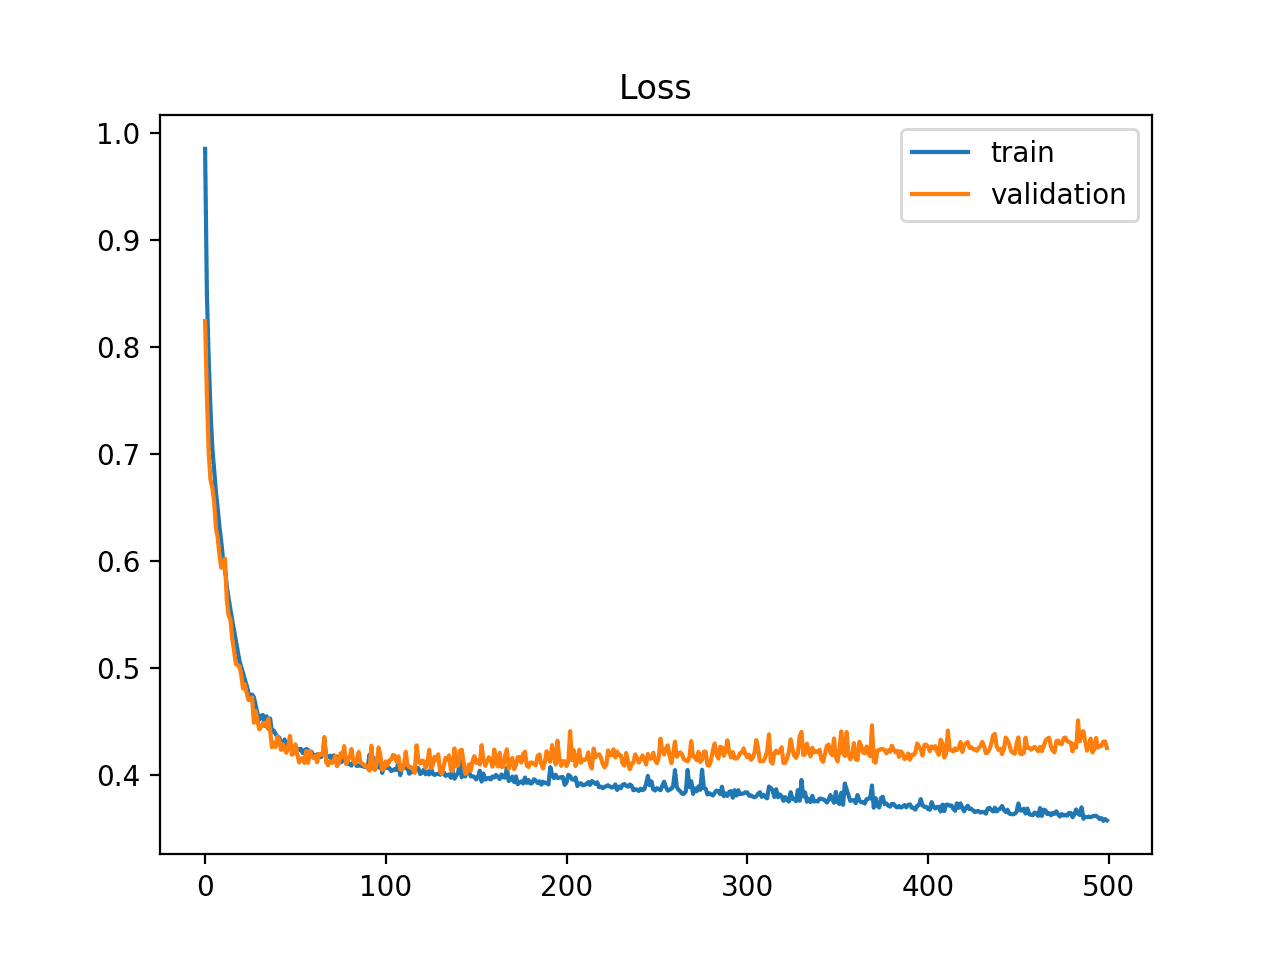

**Underfitting**
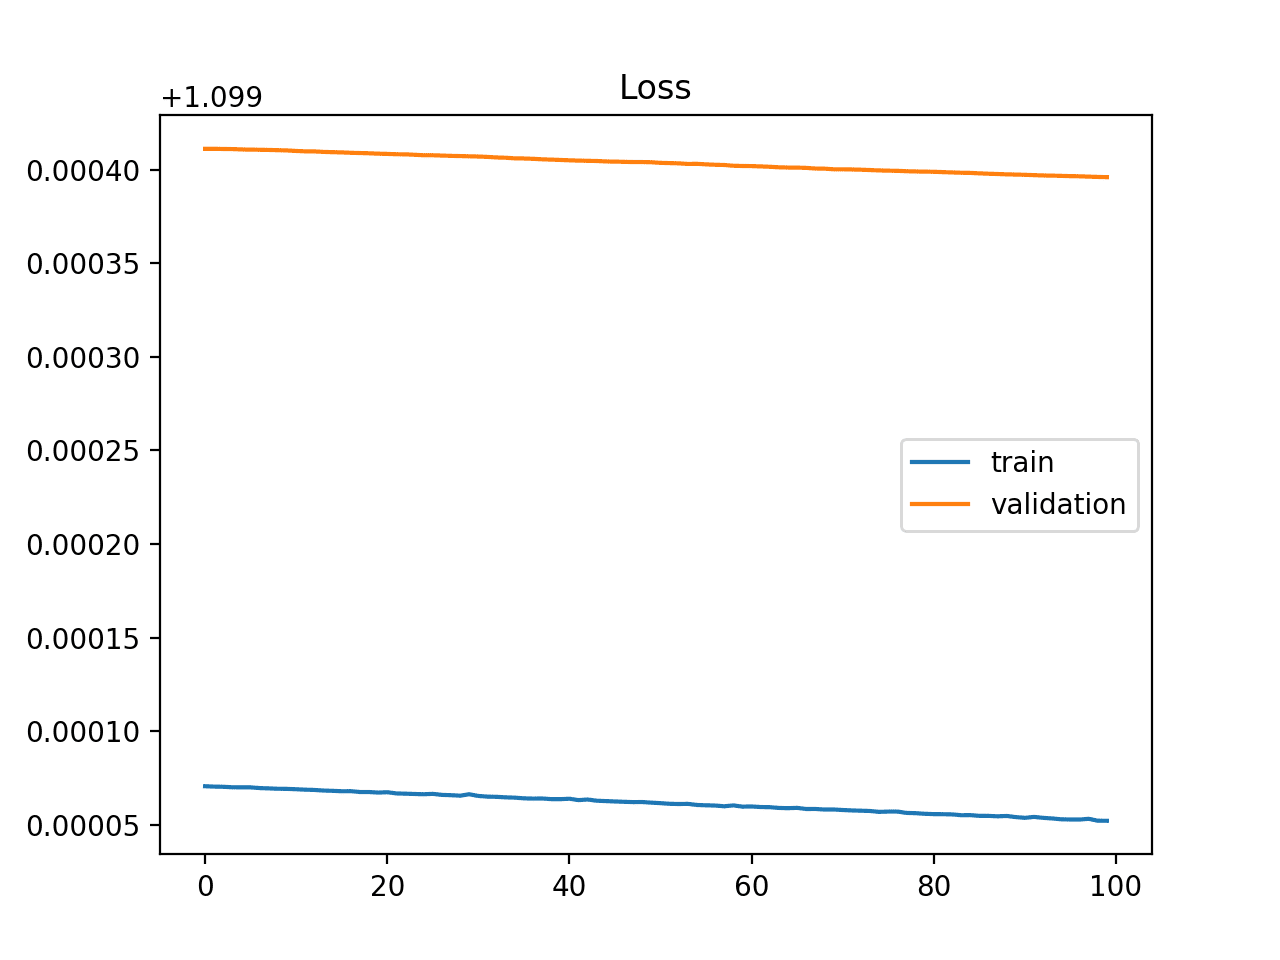

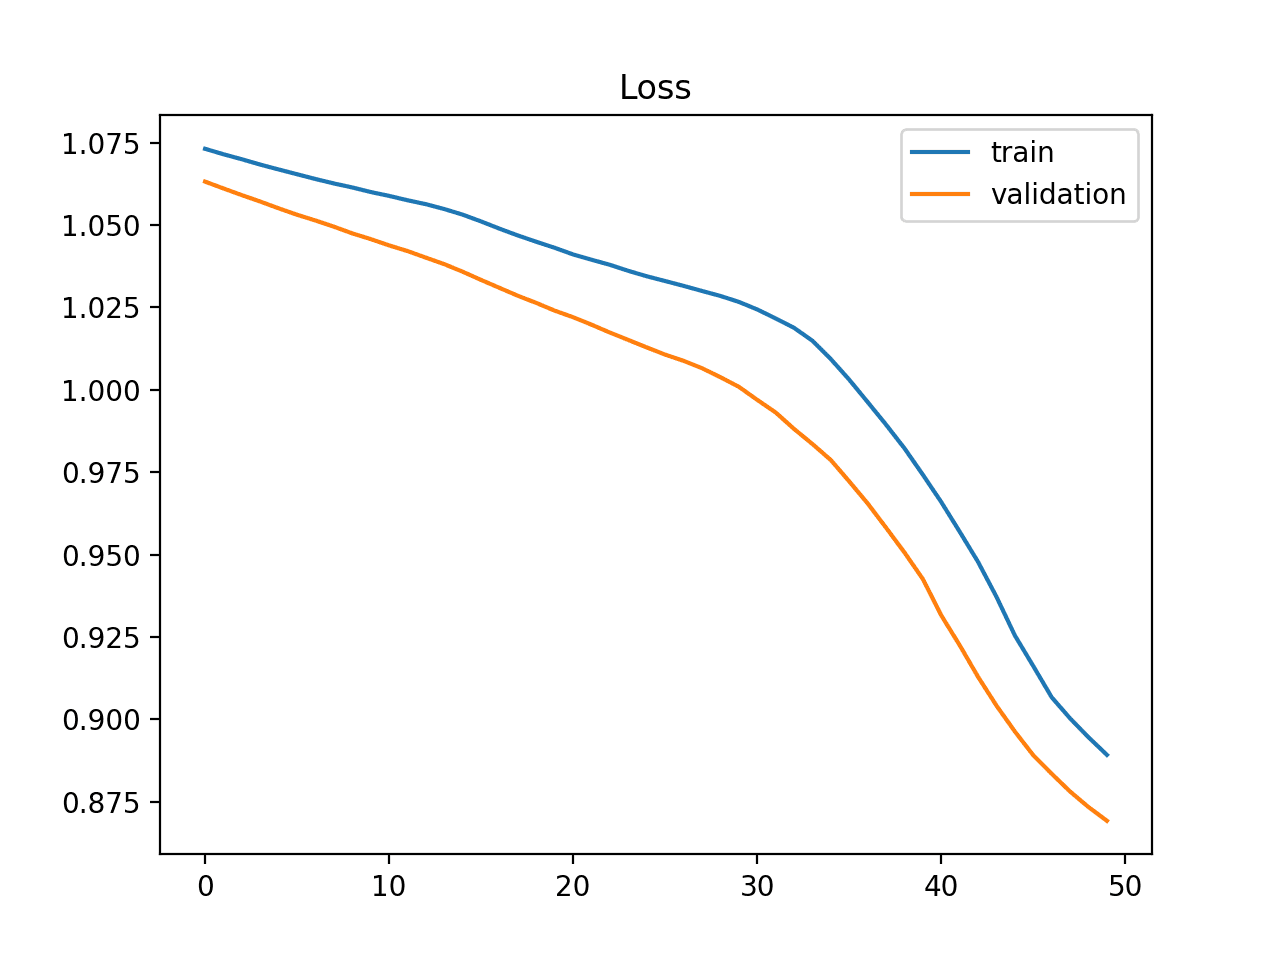

**Good Fit**

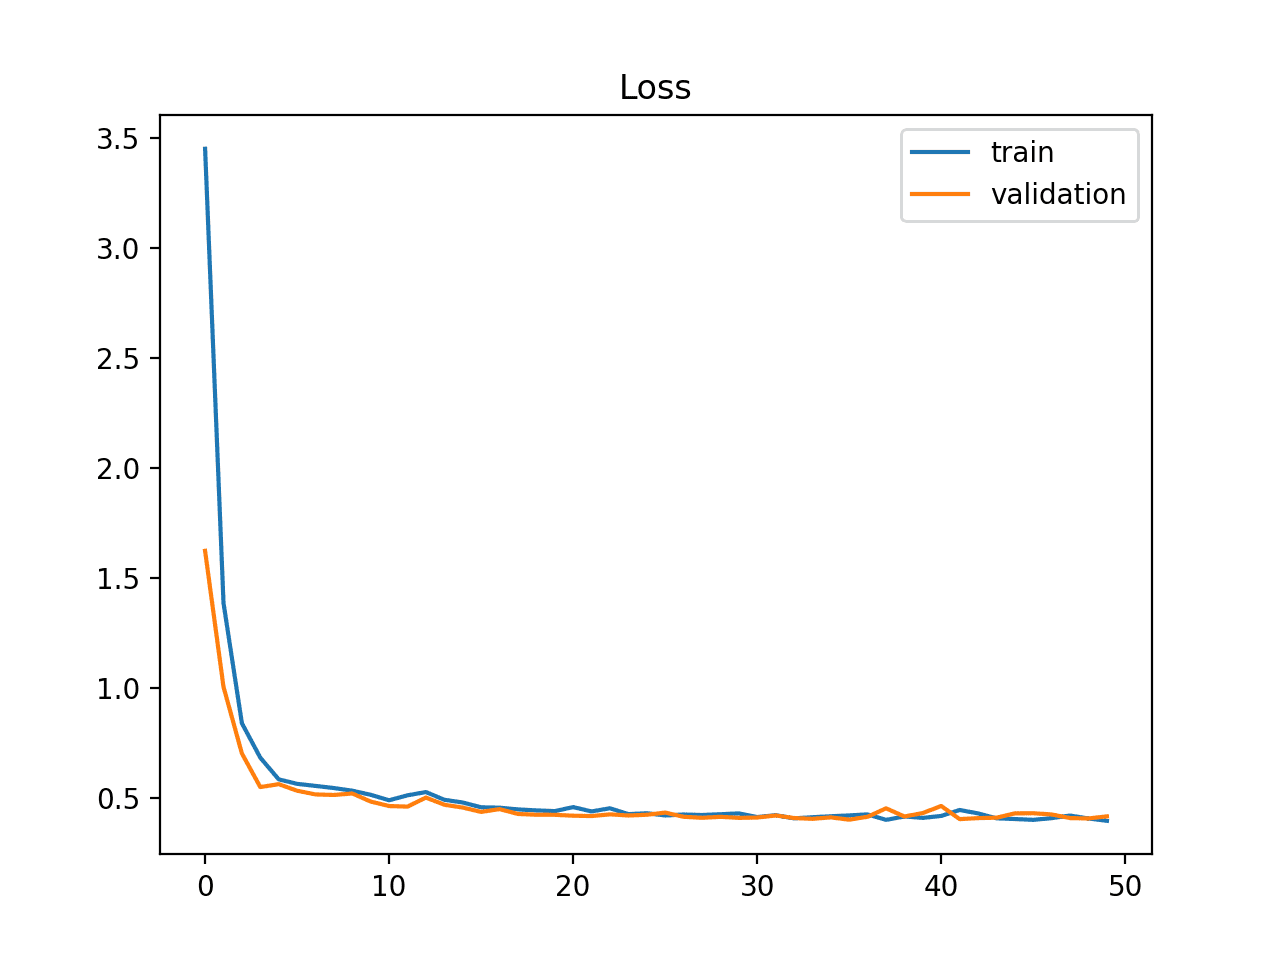

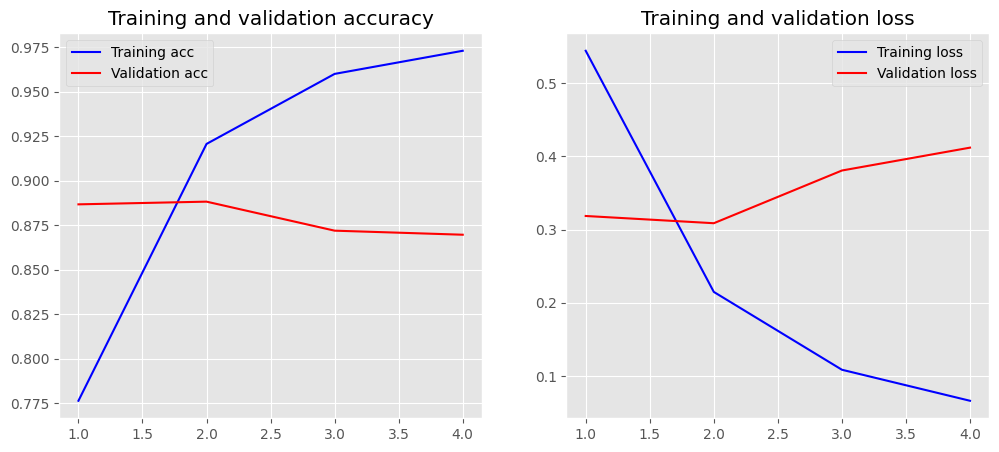

In [274]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

Hasilnya jika kita melihat visualisasinya model yang kita kembangkan tergolong Overfitting. Disinyalir karena:


*   Data training terlalu banyak
*   Proses training berlangsung lama.



In [275]:
model.save('sentiment_analysis_model_RNN_challenge.h5')
print("Model has created!")

d:\BINAR_CHALLENGE\PLATINUM_CHALLENGE\plat_challenge_main\plat_challenge_main\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has created!


# Predict

In [276]:
import re 
from keras.models import load_model

input_text = """
Rasa syukur, cukup.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('sentiment_analysis_model_RNN_challenge.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 1s 856ms/step
Text:   rasa syukur  cukup  
Sentiment:  negative
